# Imports

In [67]:
# Data manipulation
import pandas as pd
import numpy as np

# Data conversion between R and Python
import rpy2

# Options for pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 30
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Stats
from scipy import stats
from scipy.stats import norm, skew

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()
import expectexception

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython
import rpy2.robjects as robjects

# Bayesian Optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from skopt import BayesSearchCV

# Suppress Sklearn warnings
import warnings
warnings.simplefilter('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

# Additional ML libraries
import xgboost as xgb
import catboost as cb
from mlxtend.regressor import StackingRegressor

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [68]:
%%R

# load the r library
library(ggplot2)
library(ggalt)
theme_set(theme_light())

library(scales)
library(dplyr)

# Data Cleaning

In [69]:
# import datasets
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')

# Save test_ID as a series 
test_ID = test_raw.Id

# drop ID columns
train_raw.drop('Id', axis=1, inplace=True)
test_raw.drop('Id', axis=1, inplace=True)

In [70]:
train_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Outliers

In [71]:
AreaVSPrice = train_raw[['GrLivArea', 'SalePrice']]

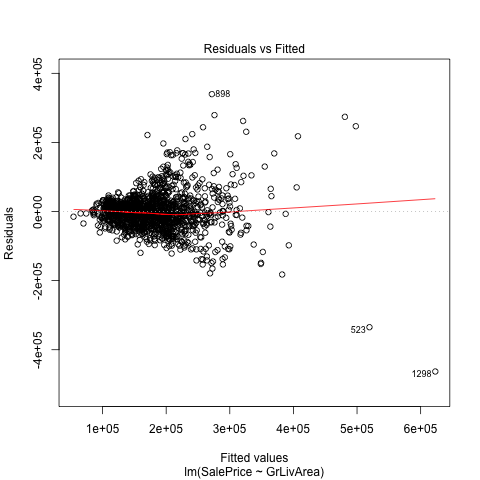

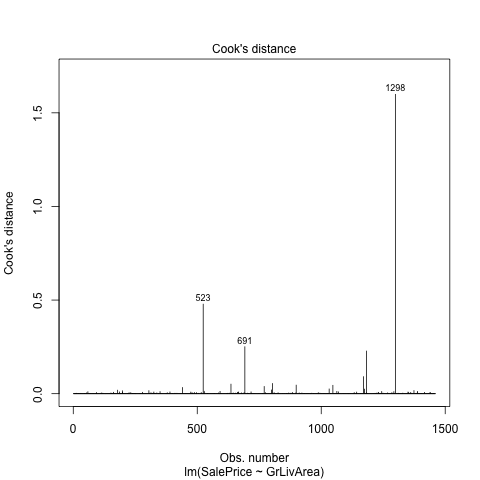

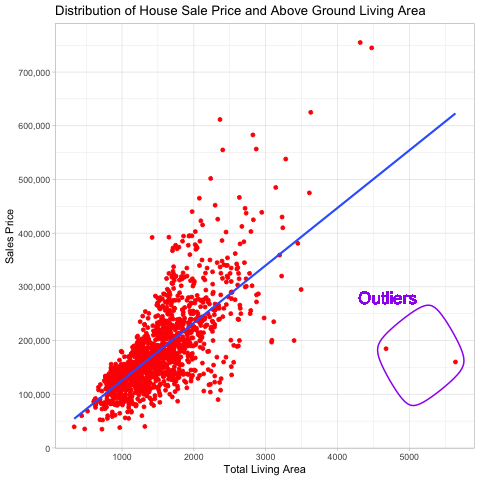

In [72]:
%%R -i AreaVSPrice

# Check residual plots and look for potential outliers
linear_model = lm(SalePrice~GrLivArea, data=AreaVSPrice)
plot(linear_model, c(1, 4))

# Note that the dataframe index starts from 0 instead of 1
outliers = AreaVSPrice %>% slice(c(524, 1299))

ggplot(AreaVSPrice, aes(x=GrLivArea, y=SalePrice)) +
    geom_point(col='red') +
    geom_encircle(aes(x=GrLivArea, y=SalePrice), 
                  data=outliers,
                  col='purple',
                  size=2,
                  expand=0.02) +
    geom_text(x=4700, y=280000, label='Outliers', col='purple', size=6) +
    geom_smooth(method='lm', aes(group=1), se=F) +
    scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price and Above Ground Living Area',
         x='Total Living Area',
         y='Sales Price')

In [73]:
# Drop the outliers
train_raw.drop(train_raw[train_raw.GrLivArea > 4500].index, inplace=True)

In [74]:
# concat the data
all_raw = pd.concat([train_raw, test_raw], ignore_index=True, sort=False)

In [16]:
AreaVSPrice_droppedOL = train_raw[['GrLivArea', 'SalePrice']]

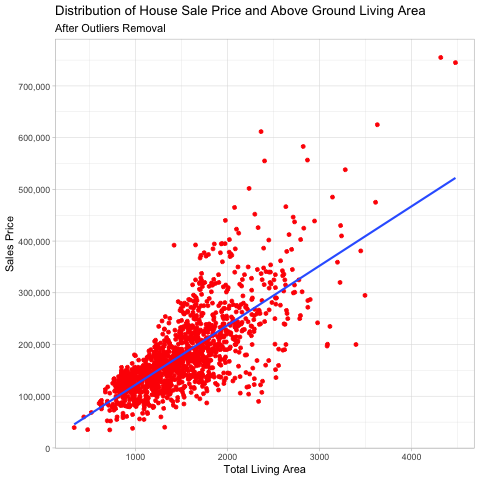

In [17]:
%%R -i AreaVSPrice_droppedOL

ggplot(AreaVSPrice_droppedOL, aes(x=GrLivArea, y=SalePrice)) +
    geom_point(col='red') +
    geom_smooth(method='lm', aes(group=1), se=F) +
    scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price and Above Ground Living Area',
         subtitle='After Outliers Removal',
         x='Total Living Area',
         y='Sales Price')

## Missing Data

In [75]:
# Columns with nan
all_raw.loc[:, all_raw.isnull().any()].columns
missing_features = len(all_raw.loc[:, all_raw.isnull().any()].columns)
print ('There are {} columns with missing data'.format(missing_features))

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SalePrice'],
      dtype='object')

There are 35 columns with missing data


In [76]:
def exam_raw(df, nullcol, columns):
    '''
    Extract rows within a dataframe for null values within target columns
    df: input dataframe
    nullcol: the columns containing the null values
    columns: columns to be shown (as a list of strings)
    '''
    return df.loc[df[nullcol].isnull(), columns]

### Individual rows to impute

#### Masonry Variables

In [77]:
exam_raw(all_raw, 'MasVnrType', ['MasVnrType', 'MasVnrArea'])

,MasVnrType,MasVnrArea
234,NaN,nan
528,NaN,nan
649,NaN,nan
935,NaN,nan
972,NaN,nan
976,NaN,nan
1242,NaN,nan
1277,NaN,nan
1689,NaN,nan
1704,NaN,nan


In [78]:
# impute by mode other than 'None' because of existing area
all_raw.loc[2608, 'MasVnrType'] = all_raw.MasVnrType.value_counts().index[1]

In [79]:
all_raw.loc[2608, 'MasVnrType']

'BrkFace'

#### Basement Variables

In [80]:
nullcount = all_raw.isnull().sum()

# Null counts for basement related variables
Bsmt_null = nullcount.loc[nullcount.index.str.contains('Bsmt')].sort_values(ascending=False)
Bsmt_null

# Slice basement related variables with greater proportion of nulls
Bsmt_with_large_NAN = Bsmt_null.loc[Bsmt_null > 50].index

BsmtExposure    82
BsmtCond        82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
BsmtHalfBath     2
BsmtFullBath     2
TotalBsmtSF      1
BsmtUnfSF        1
BsmtFinSF2       1
BsmtFinSF1       1
dtype: int64

In [81]:
# Confirm that all missing observations in 'BsmtFinType1' also corresponds to other variables
all_raw.loc[all_raw.BsmtFinType1.isnull(), Bsmt_with_large_NAN].sum()

BsmtExposure   0.000
BsmtCond       0.000
BsmtQual       0.000
BsmtFinType2   0.000
BsmtFinType1   0.000
dtype: float64

In [82]:
# Select observations where 'BsmtFinType1' are complete but missing at other columns
all_raw.loc[all_raw.BsmtFinType1.notnull() & (all_raw.BsmtQual.isnull() | 
                                              all_raw.BsmtCond.isnull() | 
                                              all_raw.BsmtExposure.isnull() | 
                                              all_raw.BsmtFinType2.isnull()), 
            Bsmt_with_large_NAN]

,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1
332,No,TA,Gd,NaN,GLQ
947,NaN,TA,Gd,Unf,Unf
1485,NaN,TA,Gd,Unf,Unf
2038,Mn,NaN,Gd,Rec,GLQ
2183,No,NaN,TA,Unf,BLQ
2215,No,Fa,NaN,Unf,Unf
2216,No,TA,NaN,Unf,Unf
2346,NaN,TA,Gd,Unf,Unf
2522,Av,NaN,TA,Unf,ALQ


In [83]:
def ModeImputer(df, indices, column):
    """
    Impute specific rows with column modes.
    df: input dataframe
    indices: indices of row (as a list of integers)
    column: column to be imputed
    """
    df.loc[indices, column] = df[column].mode()[0]

In [84]:
ModeImputer(all_raw, [947, 1485, 2346], 'BsmtExposure')
ModeImputer(all_raw, [2038, 2183, 2522], 'BsmtCond')
ModeImputer(all_raw, [2215, 2216], 'BsmtQual')
ModeImputer(all_raw, [332], 'BsmtFinType2')

#### Garage Variables

In [85]:
# Null counts for garage related variables
Garage_null = nullcount.loc[nullcount.index.str.contains('Garage')].sort_values(ascending=False)
Garage_null

# Slice basement related variables with greater proportion of nulls
Garage_var = Garage_null.index
Garage_with_large_NAN = Garage_null.loc[Garage_null > 100].index

GarageCond      159
GarageQual      159
GarageFinish    159
GarageYrBlt     159
GarageType      157
GarageArea        1
GarageCars        1
dtype: int64

In [86]:
# Confirm that all missing observations in 'GarageType' also corresponds to other variables
all_raw.loc[all_raw.GarageType.isnull(), Garage_with_large_NAN].sum()

GarageCond     0.000
GarageQual     0.000
GarageFinish   0.000
GarageYrBlt    0.000
GarageType     0.000
dtype: float64

In [87]:
# Select observations where 'GarageType' are complete but missing at other columns
all_raw.loc[all_raw.GarageType.notnull() & (all_raw.GarageCond.isnull() | 
                                              all_raw.GarageQual.isnull() | 
                                              all_raw.GarageFinish.isnull() | 
                                              all_raw.GarageYrBlt.isnull()), 
            Garage_var]

,GarageCond,GarageQual,GarageFinish,GarageYrBlt,GarageType,GarageArea,GarageCars
2124,NaN,NaN,NaN,nan,Detchd,360.000,1.000
2574,NaN,NaN,NaN,nan,Detchd,nan,nan


In [88]:
ModeImputer(all_raw, [2124], 'GarageCond')
ModeImputer(all_raw, [2124], 'GarageQual')
ModeImputer(all_raw, [2124], 'GarageFinish')

# Seems like obs 2574 doesn't really have a garage
all_raw.loc[2574, 'GarageType'] = np.nan

### Imputation for naturally non-existing data

In [89]:
# List of variables to be casted to none or zeroes
tonone = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
          'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
          'BsmtQual', 'BsmtCond', 'BsmtExposure', 
          'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

tozero = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

In [90]:
for col in tonone:
    all_raw[col] = all_raw[col].fillna('None')

In [91]:
for col in tozero:
    all_raw[col] = all_raw[col].fillna(0)

### Imputation according to mode

In [92]:
# Impute Electrical to its mode
all_raw['Electrical'].fillna(all_raw['Electrical'].mode()[0], inplace=True)

In [93]:
all_raw['Exterior2nd'].isna().sum()

1

### Random imputation

In [94]:
def random_impute(df, columns, seed):
    """
    Impute the missing values within categorical features according to proportion.
    df: input dataframe
    columns: columns to be imputed (as a list of strings)
    seed: random seed that's used
    """
    np.random.seed(seed)
    for column in columns:
        series = df[column].value_counts()
        proportion = series / series.sum()
        df[column] = df[column].fillna(np.random.choice(series.index, p=proportion))

In [95]:
random_impute(all_raw, ['MSZoning', 'SaleType',
                        'KitchenQual', 'Exterior1st', 'Exterior2nd'], 0)

### Dropping useless variables

In [96]:
all_raw.Utilities.value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [97]:
all_raw.drop(['Utilities'], axis=1, inplace=True)

### Other imputations

In [98]:
# Impute Lot Frontage stratified by median values in different neighborhoods
all_raw['LotFrontage'] = all_raw.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

In [99]:
# Impute 'Garage year built' by 'House year built'
garage_df = exam_raw(all_raw, 'GarageYrBlt', ['GarageYrBlt', 'YearBuilt'])
all_raw.GarageYrBlt.fillna(garage_df.YearBuilt, inplace=True)

In [100]:
# Impute Functional as 'Typical'
all_raw["Functional"].fillna("Typ", inplace=True)

---

In [101]:
# Check to see if there're anymore missing values
all_raw.loc[:, all_raw.isnull().any()].columns

Index(['SalePrice'], dtype='object')

# Feature Engineering

## Casting numerical features to categorical

In [102]:
all_imputed = all_raw.copy()

In [103]:
tocat = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']

In [104]:
for col in tocat:
    all_imputed[col] = all_imputed[col].astype(str)

In [105]:
train_raw.OverallCond.unique()

array([5, 8, 6, 7, 4, 2, 3, 9, 1])

## Adding variables

In [106]:
# Compute total Square Feet
all_imputed['TotalSF'] = all_imputed['TotalBsmtSF'] + \
    all_imputed['1stFlrSF'] + all_imputed['2ndFlrSF']

In [107]:
TotalSFVSPrive = all_imputed[['TotalSF', 'SalePrice']].dropna()
correlation = round(TotalSFVSPrive.corr().iloc[1,0], 3)
print('The correlation between Total SF and Sale Price is {}'.format(correlation))

The correlation between Total SF and Sale Price is 0.833


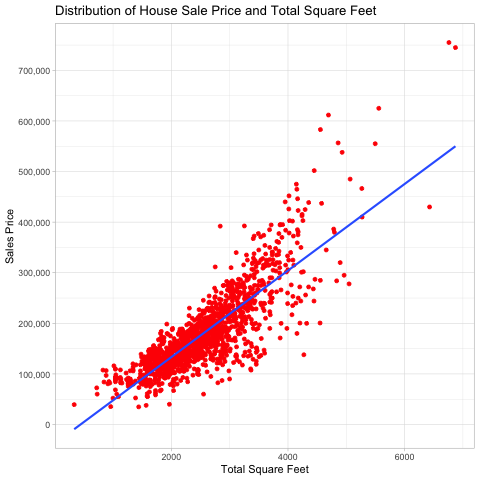

In [189]:
%%R -i TotalSFVSPrive

ggplot(TotalSFVSPrive, aes(x=TotalSF, y=SalePrice)) +
    geom_point(col='red') +
    geom_smooth(method='lm', aes(group=1), se=F) +
    scale_y_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price and Total Square Feet',
         x='Total Square Feet',
         y='Sales Price')

In [108]:
# Inflation index for Ames obtained through external site
inflationindex = {
    '2006': 240.85,
    '2007': 246.07,
    '2008': 247.23,
    '2009': 247.03,
    '2010': 245.29
}

all_imputed['InflationIndex'] = all_imputed['YrSold'].map(inflationindex)

In [109]:
cats = all_imputed.copy()

## Transforming variables

### Features

In [110]:
# Select highly skewed features
numerical_features = all_imputed.select_dtypes('number').columns
skewness = all_imputed[numerical_features].apply(lambda x: skew(x))
skewed_features = skewness[abs(skewness) > 1.5]
print('There are {} skewed features to be transformed'.format(len(skewed_features)))

# Handle rows with zeroes
skewed_features_addone = all_imputed[skewed_features.index] + 1

There are 13 skewed features to be transformed


In [111]:
# Apply boxcox transformation to all variables with skewness > 1.5
for features in skewed_features.index:
    all_imputed[features], _ = stats.boxcox(
        skewed_features_addone[features])

### Target Variable

In [112]:
price = all_imputed[['SalePrice']].dropna()

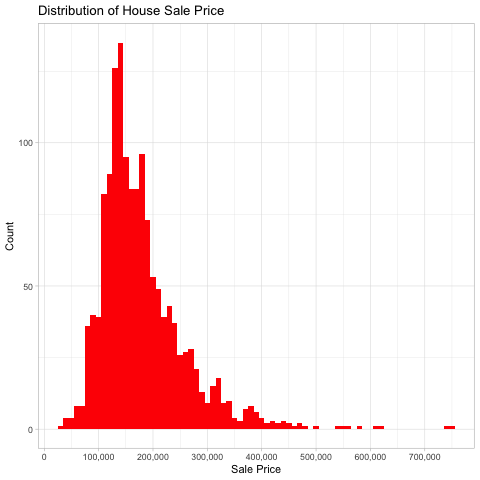

In [113]:
%%R -i price

ggplot(price, aes(x=SalePrice)) + 
    geom_histogram(fill='red', binwidth=10000) +
    scale_x_continuous(breaks=seq(0, 800000, by=100000), labels=comma) +
    labs(title='Distribution of House Sale Price',
         x='Sale Price',
         y='Count')

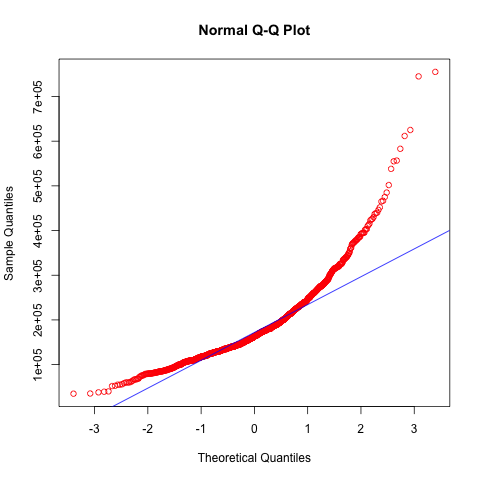

In [114]:
%%R -i price

qqnorm(price$SalePrice, col='red')
qqline(price$SalePrice, col='blue')

In [115]:
# log-transformed Sale Price
all_imputed['SalePrice'] = np.log1p(all_imputed['SalePrice'])
price = all_imputed[['SalePrice']].dropna()

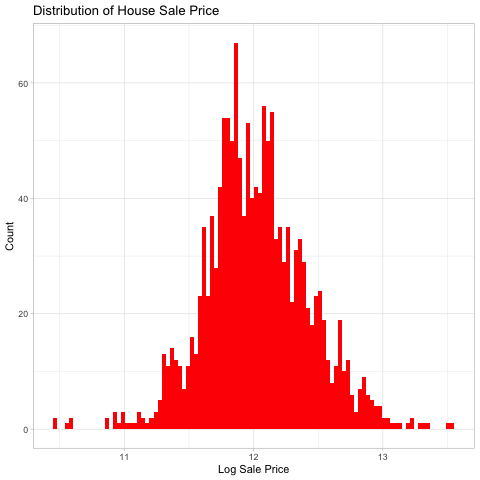

In [116]:
%%R -i price

ggplot(price, aes(x=SalePrice)) +
geom_histogram(fill='red', bins=100) +
labs(title='Distribution of House Sale Price',
     x='Log Sale Price',
     y='Count')

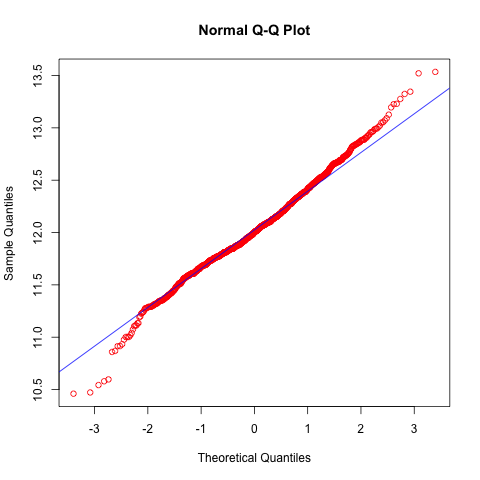

In [117]:
%%R -i price

qqnorm(price$SalePrice, col='red')
qqline(price$SalePrice, col='blue')

## Scaling and Encoding Variables

In [118]:
# Creating list of numerical and categorical features respectively
numerical_features = all_imputed.select_dtypes('number').columns.tolist()
numerical_features.remove('SalePrice')
categorical_features = all_imputed.select_dtypes('object').columns.tolist()

# Asserting all columns are selected
len(all_imputed.columns) - 1 == len(numerical_features) + len(categorical_features)

True

In [119]:
# ### Cat Route
# cats = all_imputed

In [120]:
# Transform columns that might be inherently ordinal
ordinal_cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 
        'OverallCond']

#Yr/MoSold???

lbl = LabelEncoder()
all_imputed.loc[:, ordinal_cols] = all_imputed.loc[:, ordinal_cols].apply(lbl.fit_transform)

In [121]:
# Create boolean masks for train and test datasets
train_mask = all_imputed['SalePrice'].notnull()
test_mask = all_imputed['SalePrice'].isnull()

In [122]:
# Standardize the training set and testing set accordingly
std = StandardScaler()
scaler = std.fit(all_imputed.loc[train_mask, numerical_features])

# Use the fitted scale on train set onto test set to avoid leakage
all_imputed.loc[train_mask, numerical_features] = scaler.transform(
    all_imputed.loc[train_mask, numerical_features])
all_imputed.loc[test_mask, numerical_features] = scaler.transform(
    all_imputed.loc[test_mask, numerical_features])

# ### Doing the same for Catboost
# scaler = std.fit(cats.loc[train_mask, numerical_features])
# cats.loc[train_mask, numerical_features] = scaler.transform(
#     cats.loc[train_mask, numerical_features])
# cats.loc[test_mask, numerical_features] = scaler.transform(
#     cats.loc[test_mask, numerical_features])

In [123]:
# Dummification of remaining categorical variables
all_imputed = pd.get_dummies(all_imputed)

# Split the data back into train and test sets
train = all_imputed.loc[train_mask]
test = all_imputed.loc[test_mask]

train_cat = cats.loc[train_mask]

In [124]:
# Prepare data for ML
X_train = train.drop(['SalePrice'], axis = 1)
y_train = train['SalePrice']

X_test = test.drop(['SalePrice'], axis = 1)

X_train_cat = train_cat.drop(['SalePrice'], axis = 1)

In [125]:
# Assert we have the same number of columns in X_train and X_test
X_train.shape[1] == X_test.shape[1]
print('We have {} columns in our dataset.'.format(X_train.shape[1]))

True

We have 236 columns in our dataset.


# Modelling

In [126]:
def rmse(cv):
    '''
    Prints the RMSE that is identical to Kaggle matrics.
    Used for GridSearchCV and RandomizedSearchCV.
    '''
    print('The lowest RMSE found: {}'.format(np.sqrt(np.abs(cv.best_score_))))
    
    
def cvsrmse(cv):
    '''
    Prints the RMSE that is identical to Kaggle matrics.
    Used for cross_val_score.
    '''
    print('The lowest RMSE found: {}'.format(np.sqrt(np.abs(cv.mean()))))

## Base Models

### Lasso

In [127]:
# Hyperparameters to tune
params = {'alpha': np.logspace(-5, -3, 201)}

# Instantiate the regressor
lasso = Lasso(warm_start=True)
lasso_cv = GridSearchCV(estimator=lasso, 
                        param_grid=params, 
                        cv=5, verbose=1, 
                        scoring='neg_mean_squared_error', 
                        n_jobs=-1)

lasso_cv.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1005 out of 1005 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-05, 1.02329299e-05, 1.04712855e-05, 1.07151931e-05,
       1.096478...
       6.91830971e-04, 7.07945784e-04, 7.24435960e-04, 7.41310241e-04,
       7.58577575e-04, 7.76247117e-04, 7.94328235e-04, 8.12830516e-04,
       8.31763771e-04, 8.51138038e-04, 8.70963590e-04, 8.91250938e-04,
       9.12010839e-04, 9.33254301e-04, 9.54992586e-04, 9.77237221e-04,
       1.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [128]:
rmse(lasso_cv)
print('The best parameters found: ', lasso_cv.best_params_)
lasso_base = lasso_cv.best_estimator_

The lowest RMSE found: 0.11110718494336422
The best parameters found:  {'alpha': 0.0004897788193684461}


In [134]:
lasso_t = Lasso(alpha = 0.0004897788)
lasso_t.fit(X_train, y_train)
train_score_t=lasso_t.score(X_train,y_train)
coeff_used = np.sum(lasso_t.coef_!=0)

print("number of features used: {}".format(coeff_used))

Lasso(alpha=0.0004897788, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

number of features used: 105


### Elastic-net

In [ ]:
# Hyperparameters to tune
params = {'alpha': np.logspace(-4, -3, 101),
          'l1_ratio': np.linspace(0.9, 1, 101)}

# Instantiate the regressor
e_net = ElasticNet(warm_start=True)
e_net_cv = RandomizedSearchCV(estimator=e_net, 
                              param_distributions=params, 
                              cv=5, verbose=1, n_iter=500,
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1, random_state=1)

e_net_cv.fit(X_train, y_train)

In [ ]:
rmse(e_net_cv)
print('The best parameters found: ', e_net_cv.best_params_)
e_net_base = e_net_cv.best_estimator_

### Stochastic Gradient Boosting

In [135]:
# Hyperparameters to tune
params = {
    'loss': ['huber'],
    'n_estimators': [5000],
    'learning_rate': [0.01],
    'max_depth': [3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5, 6, 7, 8, 9, 10],
    'min_samples_split': [15, 16, 17, 18, 19, 20], 
    'random_state': [1]
}

# Instantiate the regressor
gbr = GradientBoostingRegressor()
gbr_cv = RandomizedSearchCV(estimator=gbr,
                      param_distributions=params, 
                      cv=5, verbose=1, n_iter=30,
                      scoring='neg_mean_squared_error', 
                      n_jobs=-1)

gbr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 20.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [136]:
rmse(gbr_cv)
print('The best parameters found: ', gbr_cv.best_params_)
gbr_base = gbr_cv.best_estimator_

The lowest RMSE found: 0.10935195304653274
The best parameters found:  {'subsample': 0.9, 'random_state': 1, 'n_estimators': 5000, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.01}


In [151]:
X_train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=236)

In [171]:
indices = np.argsort(importances)[::-1][:10]
importances[indices]
[feature_names[i] for i in indices]
range(len(indices))[::-1]

array([0.0923572 , 0.09145425, 0.06550213, 0.05639684, 0.04731253,
       0.04701645, 0.04377822, 0.04364957, 0.04044818, 0.03717702])

['OverallQual',
 'TotalSF',
 'GrLivArea',
 'ExterQual',
 'YearBuilt',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'GarageArea',
 'YearRemodAdd']

range(9, -1, -1)

Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 10 artists>

([<matplotlib.axis.YTick at 0x133a45518>,
 <a list of 10 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

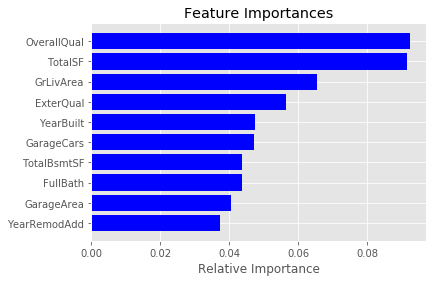

In [179]:
feature_names = X_train.columns
importances = gbr_base.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.title('Feature Importances')
plt.barh(range(len(indices))[::-1], importances[indices], color='b', align='center')
plt.yticks(range(len(indices))[::-1], [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


### Kernel Ridge

In [104]:
# Hyperparameters to tune
params = {
    'alpha': np.linspace(0, 1, 101),
    'degree': np.linspace(1, 3, 201),
    'coef0': np.linspace(2, 4, 201),
    'kernel': ['polynomial']
}

# Instantiate the regressor
krr = KernelRidge()
krr_cv = RandomizedSearchCV(estimator=krr, 
                            param_distributions=params, 
                            cv=5, verbose=1, n_iter=500,
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1, random_state=1)

krr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                         kernel='linear', kernel_params=None),
                   iid='warn', n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0...
       2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64,
       2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75,
       2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86,
       2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97,
       2.98, 2.99, 3.  ]),
                                        'kernel': ['polynomial']},
                   pre_dispatch='2*n_jobs', random_state=1, refit=True,
                   return_train_s

In [146]:
rmse(krr_cv)
print('The best parameters found: ', krr_cv.best_params_)
krr_base = krr_cv.best_estimator_

The lowest RMSE found: 0.11164292383387983
The best parameters found:  {'kernel': 'polynomial', 'degree': 1.75, 'coef0': 4.0, 'alpha': 0.24}


AttributeError: 'dict' object has no attribute 'feature_importance_'

In [139]:
feature_importance = tree_model.feature_importances_
print([t[1] for t in zip(feature_importance, train.columns) if t[0]>0])
feature_importance

AttributeError: 'KernelRidge' object has no attribute 'feature_importance'

### CatBoosting

In [214]:
# Without categoricals

params = {
    'iterations': np.linspace(750, 1000, 6),
    'learning_rate': np.round(np.linspace(0.75, 1.25, 6), 2),
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': np.linspace(5, 50, 10),
}

cbr = cb.CatBoostRegressor(
    depth=1
)

cbr_cv = RandomizedSearchCV(estimator=cbr, 
                              param_distributions=params, 
                              cv=3, verbose=1, n_iter=300,
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1, random_state=1)
  
cbr_cv.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 59.3min finished


0:	learn: 1.9103004	total: 7.69ms	remaining: 6.14s
1:	learn: 0.4375935	total: 10.9ms	remaining: 4.34s
2:	learn: 0.2942512	total: 13.4ms	remaining: 3.56s
3:	learn: 0.2780160	total: 17.9ms	remaining: 3.56s
4:	learn: 0.2740042	total: 23.1ms	remaining: 3.67s
5:	learn: 0.2464557	total: 27.7ms	remaining: 3.66s
6:	learn: 0.2426296	total: 30.6ms	remaining: 3.47s
7:	learn: 0.2310029	total: 33.3ms	remaining: 3.3s
8:	learn: 0.2219986	total: 35.9ms	remaining: 3.15s
9:	learn: 0.2202195	total: 38.3ms	remaining: 3.03s
10:	learn: 0.2130452	total: 40.5ms	remaining: 2.91s
11:	learn: 0.2128646	total: 42.8ms	remaining: 2.81s
12:	learn: 0.2025737	total: 45ms	remaining: 2.73s
13:	learn: 0.2023668	total: 47.8ms	remaining: 2.68s
14:	learn: 0.2011032	total: 49.9ms	remaining: 2.61s
15:	learn: 0.2010842	total: 52.2ms	remaining: 2.56s
16:	learn: 0.2010837	total: 54.5ms	remaining: 2.51s
17:	learn: 0.1935168	total: 56.8ms	remaining: 2.47s
18:	learn: 0.1854817	total: 59.2ms	remaining: 2.44s
19:	learn: 0.1812190	tota

217:	learn: 0.1099447	total: 584ms	remaining: 1.56s
218:	learn: 0.1099432	total: 587ms	remaining: 1.56s
219:	learn: 0.1098481	total: 590ms	remaining: 1.55s
220:	learn: 0.1098478	total: 592ms	remaining: 1.55s
221:	learn: 0.1095316	total: 595ms	remaining: 1.55s
222:	learn: 0.1095220	total: 598ms	remaining: 1.55s
223:	learn: 0.1094188	total: 600ms	remaining: 1.54s
224:	learn: 0.1093660	total: 602ms	remaining: 1.54s
225:	learn: 0.1092388	total: 604ms	remaining: 1.53s
226:	learn: 0.1092387	total: 607ms	remaining: 1.53s
227:	learn: 0.1092239	total: 609ms	remaining: 1.53s
228:	learn: 0.1092197	total: 611ms	remaining: 1.52s
229:	learn: 0.1091069	total: 614ms	remaining: 1.52s
230:	learn: 0.1091069	total: 616ms	remaining: 1.52s
231:	learn: 0.1090648	total: 619ms	remaining: 1.51s
232:	learn: 0.1090476	total: 621ms	remaining: 1.51s
233:	learn: 0.1090467	total: 624ms	remaining: 1.51s
234:	learn: 0.1089297	total: 626ms	remaining: 1.5s
235:	learn: 0.1089094	total: 629ms	remaining: 1.5s
236:	learn: 0.

376:	learn: 0.1038383	total: 969ms	remaining: 1.09s
377:	learn: 0.1038340	total: 972ms	remaining: 1.08s
378:	learn: 0.1037688	total: 974ms	remaining: 1.08s
379:	learn: 0.1037318	total: 977ms	remaining: 1.08s
380:	learn: 0.1037305	total: 979ms	remaining: 1.08s
381:	learn: 0.1036958	total: 982ms	remaining: 1.07s
382:	learn: 0.1036942	total: 984ms	remaining: 1.07s
383:	learn: 0.1036401	total: 987ms	remaining: 1.07s
384:	learn: 0.1036305	total: 990ms	remaining: 1.07s
385:	learn: 0.1035970	total: 992ms	remaining: 1.06s
386:	learn: 0.1035919	total: 994ms	remaining: 1.06s
387:	learn: 0.1035832	total: 996ms	remaining: 1.06s
388:	learn: 0.1035734	total: 999ms	remaining: 1.05s
389:	learn: 0.1035729	total: 1s	remaining: 1.05s
390:	learn: 0.1035669	total: 1s	remaining: 1.05s
391:	learn: 0.1035197	total: 1s	remaining: 1.05s
392:	learn: 0.1035193	total: 1.01s	remaining: 1.04s
393:	learn: 0.1035193	total: 1.01s	remaining: 1.04s
394:	learn: 0.1035193	total: 1.01s	remaining: 1.04s
395:	learn: 0.1035129

593:	learn: 0.1006024	total: 1.54s	remaining: 534ms
594:	learn: 0.1006023	total: 1.54s	remaining: 532ms
595:	learn: 0.1006001	total: 1.55s	remaining: 530ms
596:	learn: 0.1006000	total: 1.55s	remaining: 527ms
597:	learn: 0.1005948	total: 1.55s	remaining: 525ms
598:	learn: 0.1005916	total: 1.55s	remaining: 522ms
599:	learn: 0.1005914	total: 1.56s	remaining: 519ms
600:	learn: 0.1005808	total: 1.56s	remaining: 517ms
601:	learn: 0.1005799	total: 1.56s	remaining: 514ms
602:	learn: 0.1005736	total: 1.56s	remaining: 511ms
603:	learn: 0.1005735	total: 1.57s	remaining: 509ms
604:	learn: 0.1005567	total: 1.57s	remaining: 506ms
605:	learn: 0.1005567	total: 1.57s	remaining: 504ms
606:	learn: 0.1005554	total: 1.57s	remaining: 501ms
607:	learn: 0.1005476	total: 1.58s	remaining: 498ms
608:	learn: 0.1005466	total: 1.58s	remaining: 495ms
609:	learn: 0.1005457	total: 1.58s	remaining: 493ms
610:	learn: 0.1005454	total: 1.58s	remaining: 490ms
611:	learn: 0.1005454	total: 1.59s	remaining: 488ms
612:	learn: 

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x139a78898>,
                   iid='warn', n_iter=300, n_jobs=-1,
                   param_distributions={'border_count': array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
                                        'iterations': array([ 750.,  800.,  850.,  900.,  950., 1000.]),
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': array([0.75, 0.85, 0.95, 1.05, 1.15, 1.25])},
                   pre_dispatch='2*n_jobs', random_state=1, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=1)

In [94]:
rmse(cbr_cv)
print('The best parameters found for RSCV: ', cbr_cv.best_params_)

The lowest RMSE found: 0.1259226678741986
The best parameters found for RSCV:  {'learning_rate': 0.85, 'l2_leaf_reg': 5, 'iterations': 800.0, 'border_count': 15.0}


In [213]:
rmse(cbr_cv)
print('The best parameters found for RSCV: ', cbr_cv.best_params_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [103]:
cat_idx = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                   16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30,
                   31, 33, 37, 38, 39, 40, 51, 53, 55, 56, 57, 58, 61, 62,
                   63, 70, 71, 74, 75, 76, 77]

In [102]:
# cat_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
#        'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
#        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
#        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
#        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
#        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
#        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
#        'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
#        'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 
#        'PavedDrive', 'PoolQC', 'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

params = {
    'one_hot_max_size': np.linspace(6, 11, 6),
    'depth': np.linspace(1, 5, 5),
    'iterations': [100, 250, 500, 750, 1000],
    'learning_rate': np.round(np.linspace(0.01, 2, 9), 2),
    'l2_leaf_reg': [1, 3, 5, 10, 25, 50, 100],
    'border_count': np.linspace(5, 50, 10),
    'ctr_border_count': np.linspace(5, 50, 10)
}

cbr2 = cb.CatBoostRegressor()

cbr_cv2 = RandomizedSearchCV(estimator=cbr2, 
                              param_distributions=params, 
                              cv=3, verbose=1, n_iter=300,
                              scoring='neg_mean_squared_error', 
                              n_jobs=-1, random_state=1)
  
cbr_cv2.fit(X_train_cat, y_train, cat_features=cat_idx)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CatBoostError: Bad value for num_feature[13,72]="Shed": Cannot convert 'b'Shed'' to float

In [ ]:
rmse(cbr_cv2)
print('The best parameters found for RSCV: ', cbr_cv2.best_params_)

In [132]:
cat_raw = train_raw.fillna(-999).drop(['SalePrice'], axis=1)
types = cat_raw.dtypes
cat_raw.iloc[cat_idx].head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,-999,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,-999,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,-999,-999,-999,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,-999,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,-999,-999,-999,0,5,2007,WD,Normal
4,60,RL,84.000,14260,Pave,-999,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,-999,-999,-999,0,12,2008,WD,Normal
5,50,RL,85.000,14115,Pave,-999,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,-999,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,-999,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.000,10084,Pave,-999,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,-999,-999,-999,0,8,2007,WD,Normal


In [133]:
cat_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,-999,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,-999,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,-999,-999,-999,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,-999,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,-999,-999,-999,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,-999,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,-999,-999,-999,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,-999,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,-999,-999,-999,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,-999,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,-999,-999,-999,0,12,2008,WD,Normal


### Extreme Gradient Boosting

#### Benchmark - Random Search

In [ ]:
# Hyperparameters to tune
params = {
    'subsample': np.linspace(0.5, 0.9, 41),
    'colsample_bytree': np.linspace(0.1, 0.2, 11),
    'reg_lambda': np.linspace(0.5, 1, 51),
    'reg_alpha': np.linspace(0, 0.5, 51),
    'gamma': np.linspace(0, 0.1, 101),
    'min_child_weight': np.linspace(0.5, 2, 151)
}

# Instantiate the regressor
xgboo = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    eval_metric = 'rmse',
    verbosity=1,
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=3,
    n_jobs=4
)

xgboo_cv = RandomizedSearchCV(estimator=xgboo, 
                              param_distributions=params, 
                              cv=3, verbose=1, n_iter=500,
                              scoring='neg_mean_squared_error', 
                              n_jobs=4, random_state=1)
  
xgboo_cv.fit(X_train, y_train)

In [ ]:
rmse(xgboo_cv)
print('The best parameters found for RSCV: ', xgboo_cv.best_params_)

In [ ]:
# XGB model using Randomized Search Hyperparameters
xgboost_rm = xgb.XGBRegressor(subsample=0.59, gamma=0.007,
                              colsample_bytree=0.1684, min_child_weight=1.8642,
                              reg_alpha=0, reg_lambda=0.83,
                              n_estimators=5000, objective='reg:squarederror',
                              learning_rate=0.01, max_depth=3,
                              random_state=1)

cv_xgb_rm = cross_val_score(
    estimator=xgboost_rm, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')

xgboost_rm.fit(X_train, y_train)

In [136]:
cvsrmse(cv_xgb_rm)

The lowest RMSE found: 0.11081461057954749


#### Bayesian Optimization

In [ ]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hpsklearn import 
from time import time

def hyperopt(param_space, X_train, y_train, X_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        cbr = cbr.CatBoostRegressor(**params)
        cbr.cv = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=3, scoring='neg_mean_squared_error')
        return {'loss': cbr.cv, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
#     if best_param_values[0] == 0:
#         boosting_type = 'gbdt'
#     else:
#         boosting_type= 'dart'
    
#     clf_best = cbr.CatBoostRegressor(learning_rate=best_param_values[2],
#                                   num_leaves=int(best_param_values[5]),
#                                   max_depth=int(best_param_values[3]),
#                                   n_estimators=int(best_param_values[4]),
#                                   boosting_type=gbdt,
#                                   colsample_bytree=best_param_values[1],
#                                   reg_lambda=best_param_values[6],
#                                  )
                                  
#     clf_best.fit(X_train, y_train)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
#     print("Test Score: ", clf_best.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [ ]:
bds =  [
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.6, 0.9)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 0.1)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0, 0.5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 5)},
    {'name': 'min_child_weight', 'type': 'continuous', 'domain': (1, 2)},
    {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 0.5)},
    {'name': 'reg_lambda', 'type': 'continuous', 'domain': (0.5, 1)}
]

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}


In [96]:
# Hyperparameters to tune
bds =  [
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.6, 0.9)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 0.1)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0, 0.5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 5)},
    {'name': 'min_child_weight', 'type': 'continuous', 'domain': (1, 2)},
    {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 0.5)},
    {'name': 'reg_lambda', 'type': 'continuous', 'domain': (0.5, 1)}
]

# Optimization objective function
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                xgb.XGBRegressor(subsample=parameters[0],
                                 gamma=parameters[1],
                                 colsample_bytree=parameters[2],
                                 max_depth=int(parameters[3]),
                                 min_child_weight=parameters[4],
                                 reg_alpha=parameters[5],
                                 reg_lambda=parameters[6],
                                 n_estimators=3000,  
                                 learning_rate=0.02,
                                 n_jobs=6,
                                 objective='reg:squarederror'
                                 ), 
                X_train, y_train, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

# Maximize negative MSE
optimizer = BayesianOptimization(cv_score, 
                                 domain=bds,
                                 acquisition_jitter=0.1,
                                 num_cores=2,
                                 maximize=True)

optimizer.run_optimization(max_iter=2)

In [98]:
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
print('The lowest RMSE found: {}'.format(np.sqrt(-y_bo)[-1]))

The lowest RMSE found: 0.11566208763148841


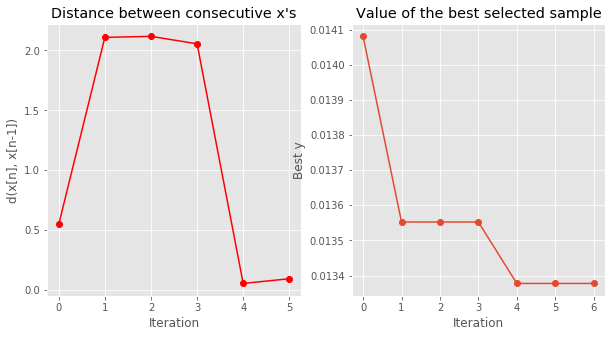

In [99]:
optimizer.plot_convergence()

In [102]:
x_best = optimizer.X[np.argmin(optimizer.Y)]
best_params = dict(zip([param['name'] for param in bds], x_best))



In [103]:
dict(zip([param['name'] for param in bds], x_best))

{'subsample': 0.8000300146337003,
 'gamma': 0.03637107709426226,
 'colsample_bytree': 0.10443837804741735,
 'max_depth': 3.0,
 'min_child_weight': 1.2444255920016027,
 'reg_alpha': 0.09829118084002675,
 'reg_lambda': 0.5480492039469815}

In [67]:
# XGB model using Bayesian Optimization Hyperparameters
xgboost = xgb.XGBRegressor(subsample=0.8, gamma=0,
                           colsample_bytree=0.1684, min_child_weight=1.8642,
                           reg_alpha=0, reg_lambda=0.5162,
                           n_estimators=2500, objective='reg:squarederror',
                           learning_rate=0.04, max_depth=3,
                           random_state=1)

cv_xgb = cross_val_score(
    estimator=xgboost, X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')

xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1684, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1.8642, missing=None,
             n_estimators=2500, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=0.5162, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8, verbosity=1)

In [68]:
cvsrmse(cv_xgb)

The lowest RMSE found: 0.11380023976233174


## Stacked Models

In [69]:
# Define base models and meta model
regressors = [e_net_base, gbr_base, krr_base]
lasso_meta = Lasso()

# Stacked model with xgb as meta model
stacked_regr = StackingRegressor(regressors=regressors,
                                 meta_regressor=lasso_meta,
                                 use_features_in_secondary=True)

# Hyperparameters to tune
params = {'meta_regressor__alpha': np.logspace(-5, -3, 101)}

stacked_cv = RandomizedSearchCV(estimator=stacked_regr, 
                                param_distributions=params,
                                cv=5, verbose=1, n_iter=20,
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1)

stacked_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=StackingRegressor(meta_regressor=Lasso(alpha=1.0,
                                                                    copy_X=True,
                                                                    fit_intercept=True,
                                                                    max_iter=1000,
                                                                    normalize=False,
                                                                    positive=False,
                                                                    precompute=False,
                                                                    random_state=None,
                                                                    selection='cyclic',
                                                                    tol=0.0001,
                                                                    warm_start=False),
              

In [70]:
rmse(stacked_cv)
print('The best parameters found: ', stacked_cv.best_params_)

The lowest RMSE found: 0.1095371461128822
The best parameters found:  {'meta_regressor__alpha': 0.0006606934480075965}


## Ensembling Estimates

In [149]:
def get_pred(fitted_model):
    '''
    Get predicted house price as a series.
    '''
    log_pred = fitted_model.predict(X_test)
    y_pred = np.expm1(log_pred)
    return y_pred


def prediction(fitted_model, model_name):
    '''
    Return rmse for prediction on the training data.
    '''
    pred = fitted_model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, pred))
    print('The rmse for {} on the training set is {:.4f}.'.format(model_name, rmse))


def ensemble_price(price1, price2, prop_price1):
    '''
    Get ensemble price for prediction.
    price1: predicted sales price for first model as a Series
    price2: predicted sales price for second model as a Series
    prop_price1: proportion of first model
    '''
    return price1*prop_price1 + price2*(1-prop_price1)


def sub(price, filename):
    """
    Create submission file for Kaggle.
    price: predicted sales price as a Series
    filename: filename as a quotted string
    """
    sub = pd.DataFrame()
    sub['Id'] = test_ID
    sub['SalePrice'] = price
    sub.to_csv(filename, index=False)

In [150]:
# Get stacked model prices
stacked_price = get_pred(stacked_cv)
xgb_price = get_pred(xgboost)
xgb_rm_price = get_pred(xgboost_rm)

# Get rmse for models
prediction(stacked_cv, 'Stack Model')
prediction(xgboost, 'XGBoost Model using Bayesian Optimization')
prediction(xgboost_rm, 'XGboost Model using Ramdomized Search')

The rmse for Stack Model on the training set is 0.0667.
The rmse for XGBoost Model using Bayesian Optimization on the training set is 0.0259.
The rmse for XGboost Model using Ramdomized Search on the training set is 0.0487.


In [151]:
# Get ensemble price
price50 = ensemble_price(stacked_price, xgb_rm_price, 50)
price55 = ensemble_price(stacked_price, xgb_rm_price, 55)
price60 = ensemble_price(stacked_price, xgb_rm_price, 60)
price65 = ensemble_price(stacked_price, xgb_rm_price, 65)
price70 = ensemble_price(stacked_price, xgb_rm_price, 70)
price75 = ensemble_price(stacked_price, xgb_rm_price, 75)

# Get submissions
sub(price50, '50stacked_xgb_rm')
sub(price55, '55stacked_xgb_rm')
sub(price60, '60stacked_xgb_rm')
sub(price65, '65stacked_xgb_rm')
sub(price70, '70stacked_xgb_rm')
sub(price75, '75stacked_xgb_rm')